# EEG Subject Identification using CNN

This project uses a Convolutional Neural Network (CNN) to identify individuals based on EEG signals recorded during Arabic speech processing.

**Model Details:**

- **Goal:** Classify EEG signals among 12 different subjects.  
- **Classification Type:** Multi-Class.  
- **Output Layer:** Softmax with 12 nodes.  
- **Loss Function:** Sparse Categorical Crossentropy.  
- **Features:**  
  - Temporal and spatial feature extraction using Conv2D and DepthwiseConv2D.  
  - Refining Blocks (Residual Dense) to enhance learning.  
  - GlobalAveragePooling to reduce dimensionality before the output layer.  
- **Input Shape:** `(samples, 8 channels, 1200 time points, 1)`  
- **Achieved Accuracy:** ~86% on the test set.  


# Imports Cell

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score


# Data Loading & Constants

In [18]:
import pandas as pd
df = pd.read_csv("EEG_classification_data.csv")

In [19]:
display(df.head())

,subject,trial,label,v0,v1,v2,v3,v4,v5,v6,...,v9591,v9592,v9593,v9594,v9595,v9596,v9597,v9598,v9599,fake_or_real
0,subject3,520,Right,705515.6875,689571.3125,687049.3125,702437.2500,711700.9375,702335.9375,687707.9375,...,232571.0781,234934.6406,242187.5156,246853.9219,239239.3125,232474.2500,234667.9375,242071.3750,246744.5000,1
1,subject1,216,Right,314953.8750,314656.3438,313871.3438,313685.1250,314355.5000,314951.3750,314660.3750,...,280992.7188,281524.8750,281714.5938,281299.2188,280849.5938,280981.5625,281506.6563,280825.9063,281156.1563,1
2,subject11,1595,Right,183549.5600,186648.1810,182215.3347,178284.6727,179933.8526,183649.7113,186850.0857,...,227306.5598,226191.8228,219465.5205,217741.6833,221166.3622,227260.1062,226159.7263,219438.7615,217722.2994,1
3,subject10,643,Right,180012.2813,180930.3125,182332.9375,182096.4531,180280.3281,179965.5313,180929.3281,...,181782.5469,186946.3281,188732.6875,183215.4688,179731.8125,181748.3906,186931.1406,188712.5625,183196.0625,0
4,subject9,608,Right,289625.8750,289505.0000,289407.6250,289464.9375,289604.1563,289624.0000,289502.3125,...,345433.6250,345834.5313,345765.6875,345314.8750,345119.9688,345429.5938,345835.7813,345766.2188,345311.3125,0


In [20]:
print(df.columns.tolist())

['subject', 'trial', 'label', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v66', 'v67', 'v68', 'v69', 'v70', 'v71', 'v72', 'v73', 'v74', 'v75', 'v76', 'v77', 'v78', 'v79', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130', 'v131', 'v132', 'v133', 'v134', 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Columns: 9604 entries, subject to fake_or_real
dtypes: float64(9600), int64(2), object(2)
memory usage: 179.5+ MB


In [22]:
NUM_CHANNELS = 8
TIME_POINTS = 1200
num_classes = 12

EPOCHS = 50
BATCH_SIZE = 32
INITIAL_LR = 1e-3

# CNN (EEG CNN Model)

--------


In [23]:
def build_eeg_model(input_shape, num_classes,
                    BASE_FILTERS=32,
                    K_TEMPORAL=25,
                    DROPOUT=0.6,
                    WEIGHT_DECAY=1e-4,
                    REFINING_BLOCKS=1):

    inp = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1, 3))(inp)

    # 1) Temporal Convolution
    x = layers.Conv2D(
        filters=BASE_FILTERS,
        kernel_size=(K_TEMPORAL, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU()(x)

    # 2) Spatial Depthwise Convolution
    x = layers.DepthwiseConv2D(
        kernel_size=(1, NUM_CHANNELS),
        depth_multiplier=1,
        depthwise_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU()(x)

    # 3) Pooling + Dropout
    x = layers.AveragePooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(DROPOUT)(x)

    # 4) تصحيح خطوة الضغط (Squeeze)
    x = layers.Lambda(lambda y: tf.squeeze(y, axis=2))(x)

    # 5) Refining Blocks (Residual Block)
    new_shape_features = x.shape[-1]

    for _ in range(REFINING_BLOCKS):
        skip = x
        x = layers.Dense(new_shape_features // 2, activation='relu')(x)
        x = layers.Dropout(DROPOUT)(x)
        x = layers.Dense(new_shape_features, activation='relu')(x)
        x = layers.Add()([x, skip])

    # 6) Global pooling + Classifier
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="EEG_SubjectID_CNN_Optimized")
    return model

# (Data Preprocessing)

(Input & Target Variables)

In [24]:
X_df = df.filter(regex=r'^v\d+$').iloc[:, : (NUM_CHANNELS * TIME_POINTS)]
Y_df = df['subject']


(Label Encoding)

In [25]:
le = LabelEncoder()
Y_encoded = le.fit_transform(Y_df)

(Train/Validation/Test Split )

In [26]:
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_df.values, Y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=Y_encoded
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp,
    test_size=0.25,
    random_state=42,
    stratify=Y_temp
)

(Scaling)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


CNN (Reshape for CNN)

In [28]:
input_shape = (NUM_CHANNELS, TIME_POINTS, 1)
X_train = X_train.reshape(-1, NUM_CHANNELS, TIME_POINTS, 1)
X_val = X_val.reshape(-1, NUM_CHANNELS, TIME_POINTS, 1)
X_test = X_test.reshape(-1, NUM_CHANNELS, TIME_POINTS, 1)

print(f"Data ready. X_train shape: {X_train.shape}")


Data ready. X_train shape: (1470, 8, 1200, 1)


# (Class Weights)

In [29]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights_dict)


Calculated Class Weights: {0: np.float64(0.98), 1: np.float64(0.9645669291338582), 2: np.float64(0.9722222222222222), 3: np.float64(0.9722222222222222), 4: np.float64(0.9722222222222222), 5: np.float64(1.4583333333333333), 6: np.float64(0.9722222222222222), 7: np.float64(0.9722222222222222), 8: np.float64(0.9722222222222222), 9: np.float64(0.9722222222222222), 10: np.float64(0.9722222222222222), 11: np.float64(0.9722222222222222)}


# (Build & Compile Model)

In [30]:
model = build_eeg_model(
    input_shape,
    num_classes,
    BASE_FILTERS=8,
    K_TEMPORAL=15,
    DROPOUT=0.4,
    REFINING_BLOCKS=0
)

optimizer = Adam(learning_rate=INITIAL_LR)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "EEG_SubjectID_CNN_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 1200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 1200, 8, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1200, 8, 8)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1200, 8, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 1200, 8, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 1200, 1, 8)     │            72 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1200, 1, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 1200, 1, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 600, 1, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           108 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372 (1.45 KB)

 Trainable params: 340 (1.33 KB)

 Non-trainable params: 32 (128.00 B)

# Callbacks

In [31]:
es_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    verbose=1,
)

mc_callback = ModelCheckpoint(
    filepath='eeg_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

callbacks_list = [es_callback, mc_callback]


# (Model Training )

In [32]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=callbacks_list,
    verbose=1,
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.0897 - loss: 2.7550

46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 372ms/step - accuracy: 0.0902 - loss: 2.7522 - val_accuracy: 0.1388 - val_loss: 2.4582
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.1381 - loss: 2.4061

46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.1386 - loss: 2.4056 - val_accuracy: 0.2122 - val_loss: 2.4309
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2365 - loss: 2.2930

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.2367 - loss: 2.2922 - val_accuracy: 0.3041 - val_loss: 2.3966
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2571 - loss: 2.1721

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.2575 - loss: 2.1715 - val_accuracy: 0.3673 - val_loss: 2.3299
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3325 - loss: 2.0317

46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.3327 - loss: 2.0310 - val_accuracy: 0.4020 - val_loss: 2.2214
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3805 - loss: 1.8963

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.3801 - loss: 1.8962 - val_accuracy: 0.4163 - val_loss: 2.0798
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3909 - loss: 1.8016

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.3910 - loss: 1.8012 - val_accuracy: 0.4429 - val_loss: 1.9339
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4269 - loss: 1.7210

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.4272 - loss: 1.7204 - val_accuracy: 0.4735 - val_loss: 1.7910
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4830 - loss: 1.6250

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.4834 - loss: 1.6246 - val_accuracy: 0.4939 - val_loss: 1.6606
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5178 - loss: 1.5448

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.5181 - loss: 1.5446 - val_accuracy: 0.5551 - val_loss: 1.5573
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5585 - loss: 1.4766

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.5584 - loss: 1.4765 - val_accuracy: 0.5694 - val_loss: 1.4701
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5471 - loss: 1.4283

46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.5477 - loss: 1.4279 - val_accuracy: 0.5816 - val_loss: 1.3970
Epoch 13/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5626 - loss: 1.3683

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.5632 - loss: 1.3678 - val_accuracy: 0.6265 - val_loss: 1.3321
Epoch 14/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.6510 - loss: 1.2871 - val_accuracy: 0.6245 - val_loss: 1.2764
Epoch 15/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6266 - loss: 1.2471

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.6266 - loss: 1.2471 - val_accuracy: 0.6408 - val_loss: 1.2278
Epoch 16/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6528 - loss: 1.1885

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.6526 - loss: 1.1888 - val_accuracy: 0.6469 - val_loss: 1.1760
Epoch 17/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6484 - loss: 1.1762

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.6484 - loss: 1.1759 - val_accuracy: 0.6694 - val_loss: 1.1351
Epoch 18/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6842 - loss: 1.1099

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.6841 - loss: 1.1101 - val_accuracy: 0.6980 - val_loss: 1.0948
Epoch 19/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6727 - loss: 1.0893

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.6729 - loss: 1.0891 - val_accuracy: 0.7122 - val_loss: 1.0620
Epoch 20/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6943 - loss: 1.0610

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.6944 - loss: 1.0608 - val_accuracy: 0.7408 - val_loss: 1.0252
Epoch 21/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6842 - loss: 1.0582

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.6845 - loss: 1.0575 - val_accuracy: 0.7490 - val_loss: 0.9891
Epoch 22/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7288 - loss: 0.9678

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.7285 - loss: 0.9681 - val_accuracy: 0.7531 - val_loss: 0.9609
Epoch 23/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7227 - loss: 0.9805

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.7229 - loss: 0.9800 - val_accuracy: 0.7694 - val_loss: 0.9315
Epoch 24/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7329 - loss: 0.9379

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7329 - loss: 0.9378 - val_accuracy: 0.7755 - val_loss: 0.9048
Epoch 25/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.7466 - loss: 0.8999 - val_accuracy: 0.7653 - val_loss: 0.8804
Epoch 26/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.7433 - loss: 0.8858 - val_accuracy: 0.7714 - val_loss: 0.8483
Epoch 27/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7358 - loss: 0.8668

46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.7360 - loss: 0.8667 - val_accuracy: 0.7776 - val_loss: 0.8256
Epoch 28/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.7681 - loss: 0.8221 - val_accuracy: 0.7714 - val_loss: 0.8109
Epoch 29/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.7329 - loss: 0.8592 - val_accuracy: 0.7714 - val_loss: 0.7868
Epoch 30/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7578 - loss: 0.7916

46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.7575 - loss: 0.7919 - val_accuracy: 0.7857 - val_loss: 0.7650
Epoch 31/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.7724 - loss: 0.7655 - val_accuracy: 0.7816 - val_loss: 0.7528
Epoch 32/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.7823 - loss: 0.7309 - val_accuracy: 0.7837 - val_loss: 0.7283
Epoch 33/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7888 - loss: 0.7483 - val_accuracy: 0.7857 - val_loss: 0.7141
Epoch 34/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7544 - loss: 0.7825

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.7549 - loss: 0.7815 - val_accuracy: 0.7898 - val_loss: 0.6999
Epoch 35/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.7684 - loss: 0.7330 - val_accuracy: 0.7898 - val_loss: 0.6861
Epoch 36/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.7568 - loss: 0.7685 - val_accuracy: 0.7878 - val_loss: 0.6678
Epoch 37/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.7848 - loss: 0.7070 - val_accuracy: 0.7837 - val_loss: 0.6591
Epoch 38/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7678 - loss: 0.7008 - val_accuracy: 0.7857 - val_loss: 0.6319
Epoch 39/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7804 - loss: 0.6969 - val_accuracy: 0.7878 - val_loss: 0.6226
Epoch 40/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7965 - loss: 0.6744

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.7963 - loss: 0.6743 - val_accuracy: 0.7959 - val_loss: 0.6130
Epoch 41/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7975 - loss: 0.6643 - val_accuracy: 0.7796 - val_loss: 0.6203
Epoch 42/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8059 - loss: 0.6101

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.8058 - loss: 0.6105 - val_accuracy: 0.8102 - val_loss: 0.5865
Epoch 43/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7930 - loss: 0.6315

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.7932 - loss: 0.6314 - val_accuracy: 0.8122 - val_loss: 0.5676
Epoch 44/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8015 - loss: 0.6020

46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.8016 - loss: 0.6020 - val_accuracy: 0.8245 - val_loss: 0.5672
Epoch 45/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8216 - loss: 0.5797 - val_accuracy: 0.8204 - val_loss: 0.5591
Epoch 46/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.8048 - loss: 0.6074 - val_accuracy: 0.7980 - val_loss: 0.5737
Epoch 47/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - accuracy: 0.8180 - loss: 0.5868 - val_accuracy: 0.8224 - val_loss: 0.5339
Epoch 48/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.8134 - loss: 0.5880 - val_accuracy: 0.8163 - val_loss: 0.5317
Epoch 49/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8076 - loss: 0.5779

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.8077 - loss: 0.5778 - val_accuracy: 0.8347 - val_loss: 0.5119
Epoch 50/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8380 - loss: 0.5339

46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.8376 - loss: 0.5346 - val_accuracy: 0.8592 - val_loss: 0.5405
Restoring model weights from the end of the best epoch: 50.


# Plot Accuracy & Loss


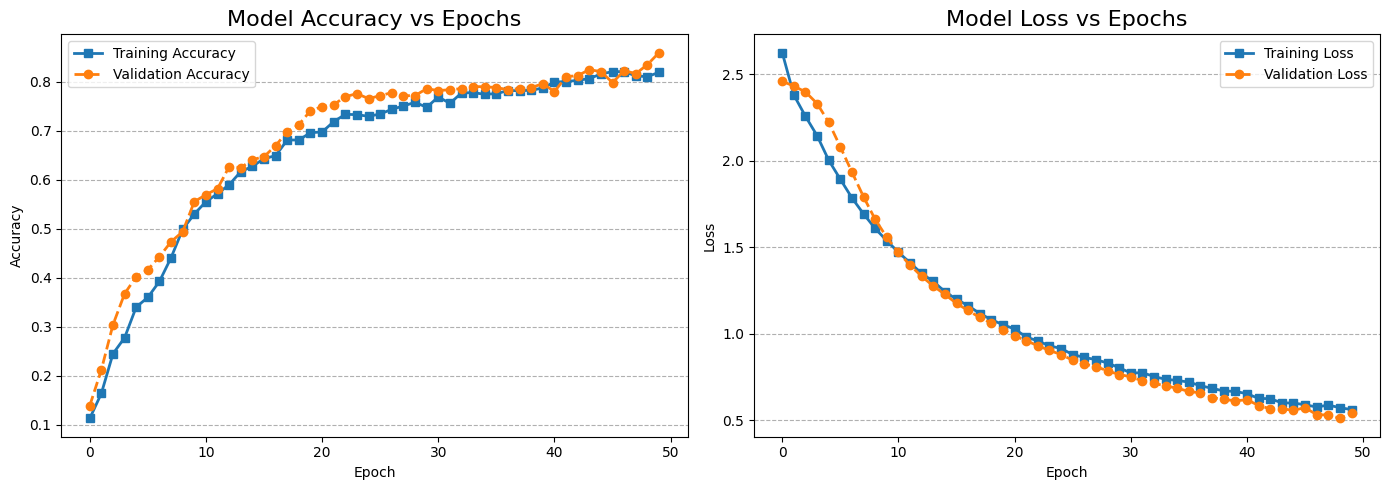

In [33]:
import matplotlib.pyplot as plt

# الرسم البياني للدقة (Accuracy)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#1f77b4', linewidth=2, marker='s')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=2, linestyle='--', marker='o')
plt.title('Model Accuracy vs Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y', linestyle='--')

# الرسم البياني للخسارة (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linewidth=2, marker='s')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2, linestyle='--', marker='o')
plt.title('Model Loss vs Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Plot F1-Score per Subject

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step


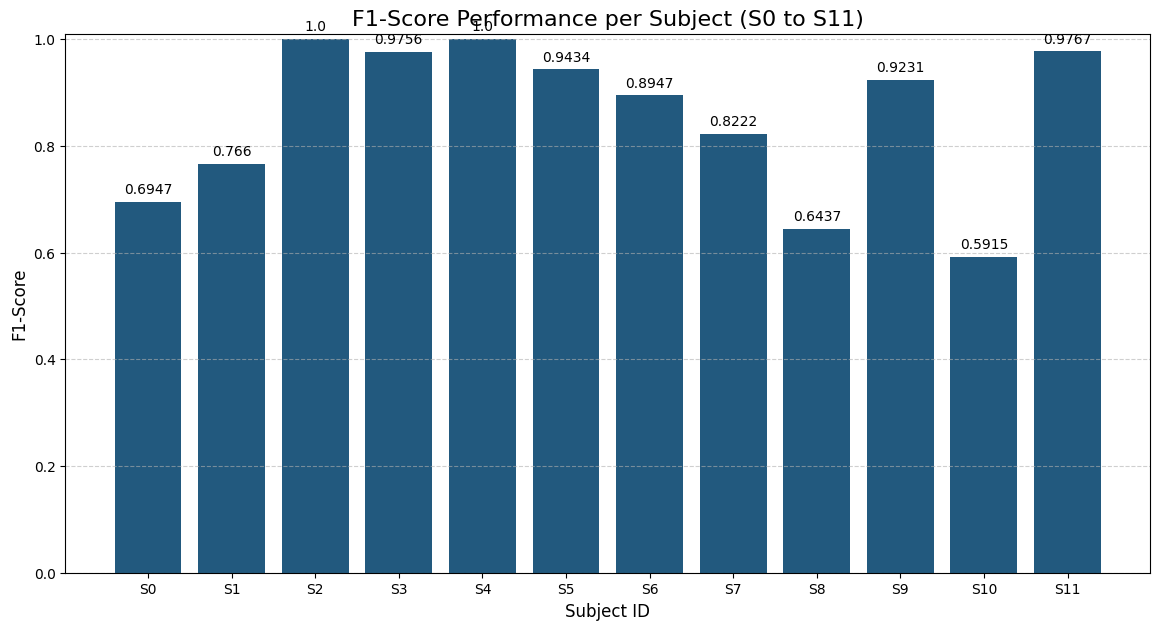

In [36]:
# افترض أن لديك بيانات الاختبار X_test و y_test
# و نموذجك تم تدريبه بالفعل باسم model

# التنبؤ على مجموعة الاختبار
y_pred_prob = model.predict(X_test)         # يعطي الاحتمالات لكل فئة
Y_pred = y_pred_prob.argmax(axis=1)         # تحويل الاحتمالات إلى الفئة الأعلى
Y_true = Y_test                              # القيم الحقيقية

# الآن يمكن تشغيل كود F1-Score per Subject بدون مشاكل
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

NUM_SUBJECTS = 12
report = classification_report(Y_true, Y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(NUM_SUBJECTS)]
subject_names = [f'S{i}' for i in range(NUM_SUBJECTS)]

plt.figure(figsize=(14, 7))
bars = plt.bar(subject_names, f1_scores, color='#0A4770', alpha=0.9)
plt.title('F1-Score Performance per Subject (S0 to S11)', fontsize=16)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0.0, 1.01)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

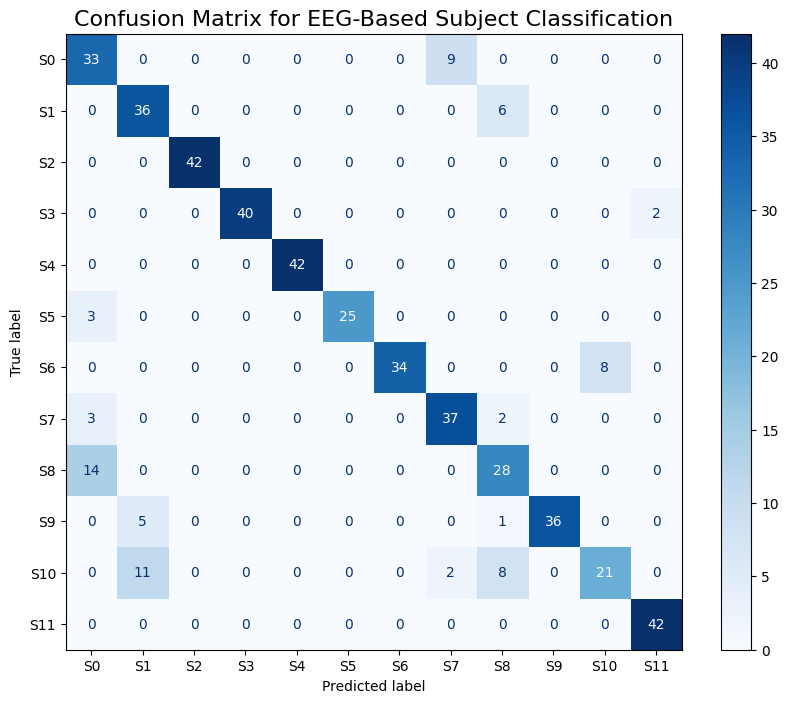

In [37]:
# استيراد المكتبات المطلوبة
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# افترض أن Y_true و Y_pred موجودان
cm = confusion_matrix(Y_true, Y_pred)

# إنشاء رسم مصفوفة الالتباس
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[f'S{i}' for i in range(NUM_SUBJECTS)])

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Confusion Matrix for EEG-Based Subject Classification', fontsize=16)
plt.show()


 Test & Evaluate Model


In [40]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)

Y_pred_raw = model.predict(X_test, verbose=0)
Y_pred_classes = np.argmax(Y_pred_raw, axis=1)

print("-" * 50)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")
print("-" * 50)

report = classification_report(Y_test, Y_pred_classes, output_dict=True)
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

--------------------------------------------------
Final Test Accuracy: 84.90%
Final Test Loss: 0.5368
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.69        42
           1       0.69      0.86      0.77        42
           2       1.00      1.00      1.00        42
           3       1.00      0.95      0.98        42
           4       1.00      1.00      1.00        42
           5       1.00      0.89      0.94        28
           6       1.00      0.81      0.89        42
           7       0.77      0.88      0.82        42
           8       0.62      0.67      0.64        42
           9       1.00      0.86      0.92        42
          10       0.72      0.50      0.59        42
          11       0.95      1.00      0.98        42

    accuracy                           0.85       490
   macro avg       0.87      0.85      0.85       490
weighted av